In [2]:
import pandas as pd

ref = pd.read_pickle('fragmenstein_hit_replacements_pairs.pkl.gz')
pairs = pd.read_pickle('fragmenstein_placed_pairs.pkl.gz')
trio = pd.read_pickle('fragmenstein_placed_trio.pkl.gz')

In [212]:
combo = pd.concat([pairs, trio], ignore_index=True)
analogs = combo.loc[combo.outcome == 'acceptable'].copy();
len(ref), len(pairs), len(trio), len(combo), len(analogs)

(41, 9250, 6031, 15281, 1583)

In [200]:
from typing import List
import operator
from rdkit import Chem

hits: List[Chem.Mol] = ref.hit_mols.apply(operator.itemgetter(0)).to_list()

ori_weights = {"N_rotatable_bonds": 1.5,
             "\u2206\u2206G": 1,
             "interaction_uniqueness_metric": -3,
             "N_unconstrained_atoms": 0.2,
             "N_constrained_atoms": -0.1,
             "N_interactions": -2,
             "N_interactions_lost": 2,
             "max_hit_Tanimoto": -0.3,
             "N_PAINS": 7,
             "strain_per_HA": 0.3}


energy_weights = {"N_rotatable_bonds": 1,
                  "\u2206\u2206G": 1,
                  "strain_per_HA": 0.3}

from fragmenstein import Laboratory

Laboratory.score(analogs, ref,
                 suffix='',
                 hits=hits,
                 weights=energy_weights,)

analogs['energy_penalty'] = analogs.ad_hoc_penalty

Laboratory.score(analogs, ref,
                 suffix='',
                 hits=hits,
                 weights=ori_weights,)

analogs['full_penalty'] = analogs.ad_hoc_penalty

analogs = analogs.copy()

In [201]:
# from kmodes.kmodes import KModes
# import pandera.typing as pdt

# k = 25

# intxn_cols = [c for c in analogs.columns if isinstance(c, tuple)]
# data_for_clustering = analogs.loc[analogs.outcome == 'acceptable'][intxn_cols].fillna(0)
# tallies = data_for_clustering.sum().to_dict()
# # probability scaled
# data_for_clustering = data_for_clustering.apply(lambda col: col / tallies[col.name],axis=0).fillna(0)

# #km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1)
# #labels = km.fit_predict(data_for_clustering)

# from scipy.cluster.vq import kmeans, vq

# centroid, variance = kmeans(data_for_clustering.values, k)
# labels, _ = vq(data_for_clustering.values, centroid)
# # list to series first for the correct indices:
# data_for_clustering['cluster_label']: pdt.Series[int] = labels
# analogs['cluster_label']: pdt.Series[float] = data_for_clustering.cluster_label
# analogs['cluster_label']: pdt.Series[int] = analogs['cluster_label'].fillna(-1).astype(int)

In [202]:
# get rid of non-xchem only vcs
def has_xchem(names):
    return any([name.replace('A71EV2A-', '')[0] == 'x' for name in names])

analogs['xchem_based'] = analogs.hit_names.apply(has_xchem)
analogs = analogs.loc[analogs.xchem_based]

In [203]:
from kmodes.kmodes import KModes
import pandera.typing as pdt

k = 10

intxn_cols = [c for c in analogs.columns if isinstance(c, tuple)]
data_for_clustering = analogs.loc[analogs.outcome == 'acceptable'][intxn_cols].fillna(0).copy()
tallies = data_for_clustering.sum().to_dict()
# probability scaled
#data_for_clustering = data_for_clustering.apply(lambda col: col / tallies[col.name],axis=0).fillna(0)

# rubbish scaled
def scale(col):
    if col.name[0] == 'hydroph_interaction':
        w = 0.5
    if col.name[0] in 'halogenbond':
        w = 1.5
    elif col.name[0] == 'saltbridge':
        w = 2.0
    else:
        w = 1.0
    return col * w

data_for_clustering = data_for_clustering.apply(scale, axis=0).fillna(0)

from scipy.cluster.vq import kmeans, vq

centroid, variance = kmeans(data_for_clustering.values, k)
labels, _ = vq(data_for_clustering.values, centroid)
# list to series first for the correct indices:
data_for_clustering['cluster_label']: pdt.Series[int] = labels
analogs['cluster_label']: pdt.Series[float] = data_for_clustering.cluster_label
analogs['cluster_label']: pdt.Series[int] = analogs['cluster_label'].fillna(-1).astype(int)

In [204]:
from collections import defaultdict
from Bio.SeqUtils import seq1
rank = defaultdict(int)

def r(c):
    rank[c] += 1
    return rank[c]

def narrate(row: pd.Series):
    grouped = defaultdict(list)
    for name, value in row.items():
        if not isinstance(name, tuple) or value == 0.:
            continue
        itxn_type, resn, resi = name
        grouped[itxn_type].append(seq1(resn, undef_code="X")+str(resi))
    narrative = f'cluster #{row.cluster_label} (rank {row.cluster_rank}); '
    for itxn_type in sorted(grouped):
        narrative += f'{itxn_type}:{"+".join(grouped[itxn_type])}; '
    return narrative

# 'cluster' is Similarity cluster
analogs = analogs.sort_values('full_penalty').drop_duplicates('cluster').reset_index(drop=True)
analogs['cluster_rank'] = analogs['cluster_label'].apply(r)
analogs['rationale'] = 'info ' + analogs.apply(narrate, axis=1)
assert analogs['rationale'].apply(len).max() < 255, 'Fix length!'
analogs = analogs.sort_values(['cluster_rank', 'full_penalty']).reset_index(drop=True).copy()

In [205]:
from gist_import import GistImporter

# fu for fragalysis upload
fmodule = GistImporter.from_github('https://raw.githubusercontent.com/matteoferla/Fragment-hit-follow-up-chemistry/main/followup/prep_fragalysis.py')
prep = fmodule['prep']
generate_header = fmodule['generate_header']
floatify_columns = fmodule['floatify_columns']

In [206]:
def catalogize(name):
    if name[0] == 'Z':
        return name.split('-')[0]
    if name[0] == 'P':
        return 'PV-'+name.split('-')[1]
    else:
        return name

analogs['catalog_id'] = analogs.name.apply(catalogize)

In [207]:
wanted_key_types = {'rationale': str, 
               'cluster_rank': int,
               'N_interactions': int, 
               'N_interactions_lost': int,
               '∆∆G': float, 
                    'comRMSD': float,
                    'N_rotatable_bonds': int, 
                     'N_unconstrained_atoms': int,
                    'N_constrained_atoms': int
                   }

for k, ktype in wanted_key_types.items():
    analogs[k] = analogs[k].astype(ktype)

wanted_keys = list(wanted_key_types)

def clean_names(names):
    deprefixed = [name.replace('A71EV2A-', '').split('S')[0] for name in names]
    return ','.join([name for name in deprefixed if name[0] == 'x'])

analogs['ref_mols'] = analogs.hit_names.apply(clean_names)

header: Chem.Mol = generate_header(method='A71-Fragmenstein',
                         ref_url='https://www.example.com',
                         submitter_name='Matteo Ferla',
                         submitter_email='matteo.ferla@stats.ox.ac.uk',
                         submitter_institution='University of Oxford',
                         extras=dict(zip(wanted_keys, wanted_keys))
                                  )
                                   
prep(analogs.head(200), 
     header, mol_col='minimized_mol', 
     name_col='catalog_id',
     outfile=f'A71_fragmenstein_clustered4.sdf',
     ref_pdb_name='x0554_0A',
     extras=wanted_keys
    )

[07:34:10] Molecule does not have explicit Hs. Consider calling AddHs()


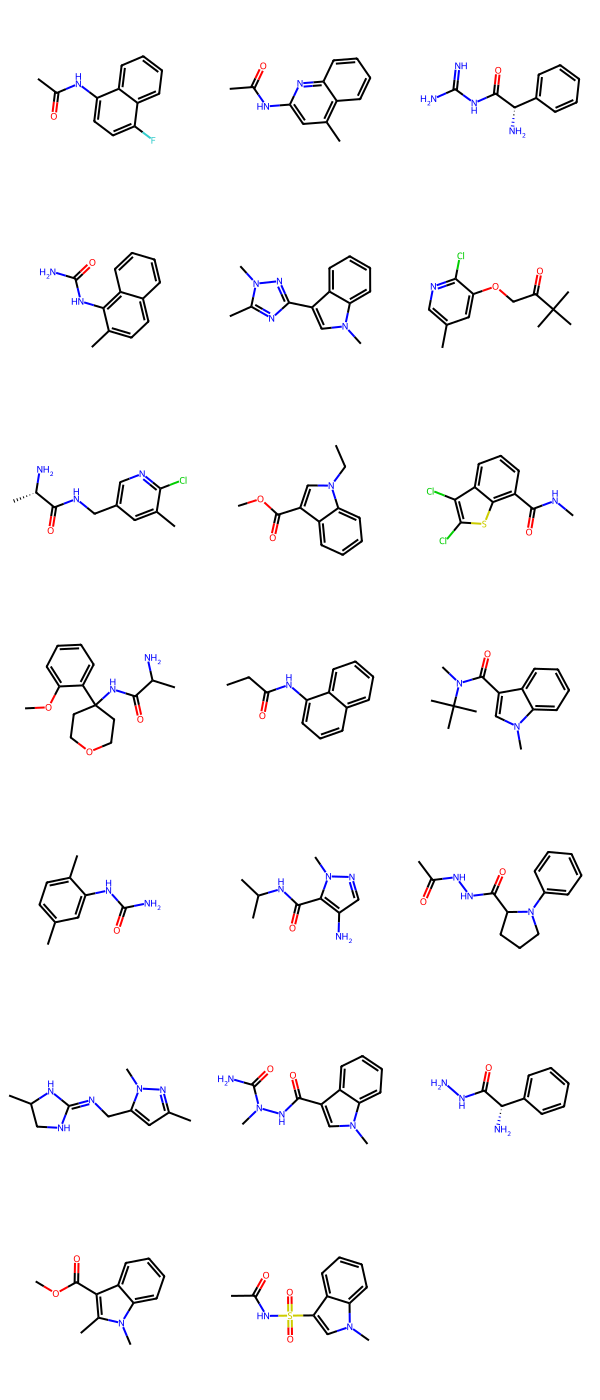

In [211]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(analogs.head(20).smiles.apply(Chem.MolFromSmiles))

In [54]:
# import numpy as np
# import numpy.typing as npt

# cluster_itxns = []
# for i in range(25):
#     wanted = list( *np.where(centroid[i] > 0) )
#     cluster_itxns.append( sorted([itxn for x, itxn in enumerate(intxn_cols) if x in wanted], key=operator.itemgetter(0)) )

In [ ]:
from collections import defaultdict
from Bio.SeqUtils import seq1

# def narrate(row: npt.ArrayLike[float], labels: List[Tuple[str, str, int]]):
#     wanted = list( *np.where(centroid_row > 0) )
#     itxns = [itxn for x, itxn in enumerate(labels) if x in wanted]
#     grouped = defaultdict(list)
#     for itxn_type, resn, resi in itxns:
#         grouped[itxn_type].append(seq1(resn, undef_code="X")+str(resi))
    
#     return 

In [ ]:
import pandas as pd
import numpy as np
import numpy.typing as npt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
import plotly.express as px

fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in analogs.minimized_mol]
fp_array: npt.NDArray[bool] = np.array([list(fp) for fp in fps])

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(fp_array)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE-1', 'TSNE-2'])

# Plot the t-SNE results using Plotly Express
fig = px.scatter(tsne_df, x='TSNE-1', y='TSNE-2', title='t-SNE Visualization of Compounds')
fig.show()